# Autoencoders for denoising
This is another example of using an autoencoder but where we are using it as a method for removing noise from images.

In [55]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


Let's load the MNIST dataset

In [57]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Now we are building our autoencoder. It is composed by an encoder and a decoder, in this case CNNs which turns out to be pretty good for computer vision. Also note that they are symmetric.

In [58]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 6, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(6, 12, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 3, stride=2, padding=1),
            nn.ReLU()  
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(24, 12, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 6, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(3, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [59]:
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(24, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(6, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(3, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)


This function will add noise to our images, in this case we will use an uniform distribution.

In [60]:
def noisy_img(img, batch_size):
  return 0.4*img + 0.6*torch.rand(batch_size, 1, 28, 28).to(device)

Let's prepare for training, we will use MSE as our loss function and Adam as optimizer algorithm. The training is a typical training loop in pytorch.

In [61]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [62]:
epochs = 10
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        noisy = noisy_img(img, img.size()[0])
        recon = model(noisy)
        recon = transforms.functional.crop(recon, 1, 1, 28, 28)
        loss = loss_fn(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.0706
Epoch:2, Loss:0.0595
Epoch:3, Loss:0.0553
Epoch:4, Loss:0.0483
Epoch:5, Loss:0.0425
Epoch:6, Loss:0.0327
Epoch:7, Loss:0.0306
Epoch:8, Loss:0.0261
Epoch:9, Loss:0.0238
Epoch:10, Loss:0.0222


Let's see some reconstructed images to see how well it did.

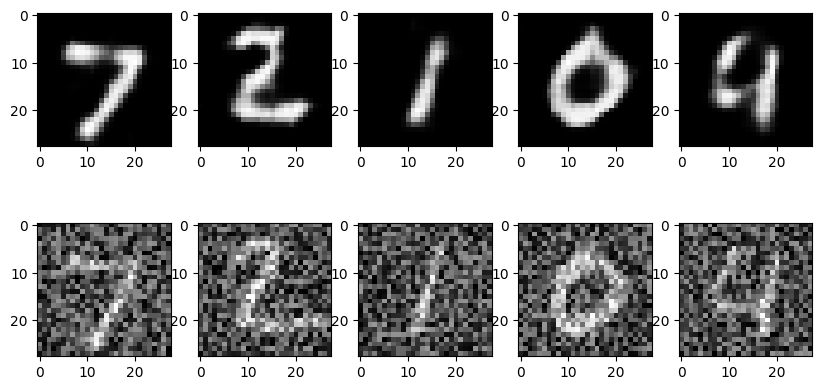

In [65]:
plt.figure(figsize=(10, 5))
for i in range(5):
    img, _ = test_data[i]
    img = img.to(device)
    noisy = noisy_img(img, 1)
    recon = model(noisy)
    recon = transforms.functional.crop(recon, 1, 1, 28, 28)
    recon = recon.squeeze().cpu().detach().numpy()
    plt.subplot(2, 5, i+1)
    plt.imshow(recon, cmap='gray')
    plt.subplot(2, 5, i+6)
    plt.imshow(noisy.squeeze().cpu().detach().numpy(), cmap='gray')